In [1]:
# display inline plots
%matplotlib inline

# import libraries for numerical and scientific computing
import numpy as np

# import matplotlib for plotting
import matplotlib.pyplot as plt

# import pandas for data wrangling and munging
import pandas as pd

# set some options for better view
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# import plotting library built on top of matplotlib
import seaborn as sns

# set some settings related to style of plots that will render
sns.set_style("whitegrid")
sns.set_context("poster")

import warnings
warnings.filterwarnings('ignore')

C:\Users\Abhishek\Anaconda2\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
from utils import load_data_set, lowercase_column_names
from eval import eval_models

In [3]:
train, test = load_data_set()
train, test = lowercase_column_names(train, test)

Loading datasets
Set ID as index


## Shape of the datasets

In [4]:
print 'Training data set {} and Test data set {}'.format(train.shape, test.shape)

Training data set (3998, 37) and Test data set (1500, 37)


## Feature preparation

In [5]:
train['jobcity'] = train.jobcity.astype('str')
test['jobcity'] = test.jobcity.astype('str')

In [6]:
def preprocess_city_name(city_name):
    city_name = city_name.strip()
    city_name = city_name.lower()
    return city_name

train['jobcity'] = train.jobcity.map(preprocess_city_name)
test['jobcity'] = test.jobcity.map(preprocess_city_name)

In [7]:
from features import FeatureTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.feature_selection import SelectKBest, f_regression

## Features and Target variable

In [8]:
from sklearn.cross_validation import train_test_split

In [9]:
X = train[train.columns.drop('salary')]
y = train.salary

## Split into training and test set

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)

## Linear Regression

In [11]:
ft = FeatureTransformer(train, test)
sel = SelectKBest(f_regression, k=10)
scaler = StandardScaler()
lm = LinearRegression()

In [12]:
pipeline = Pipeline([('transformer', ft), ('scaler', scaler), ('sel', sel), ('lm', lm)])

In [13]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('transformer', FeatureTransformer(test=None, train=None)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('sel', SelectKBest(k=10, score_func=<function f_regression at 0x000000001F767908>)), ('lm', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [14]:
lm_comp = pipeline.get_params()['lm']

In [15]:
print 'Estimated intercept coefficient:', lm_comp.intercept_

Estimated intercept coefficient: 306946.216385


In [16]:
print 'Number of coefficients:', len(lm_comp.coef_)

Number of coefficients: 10


In [17]:
feature_names = pipeline.get_params()['transformer'].get_feature_names()

In [18]:
# The coefficients
pd.DataFrame(zip(feature_names, lm_comp.coef_), columns = ['features', 'estimatedCoefficients'])

,features,estimatedCoefficients
0,year_of_birth,-20653.505632
1,jobcity,15070.153990
2,gender,-25928.438857
3,degree,24444.682890
4,specialization,-11909.089430
5,collegestate,-24814.883419
6,10percentage,10977.498696
7,12graduation,14774.136057
8,12percentage,9656.975839
9,collegeid,18496.217841


In [19]:
# lets take a look at first five predicted values
pipeline.predict(X_train)[0:5]

array([ 317113.09424033,  396277.80340079,  272066.01596639,
        470774.00038848,  192688.56945305])

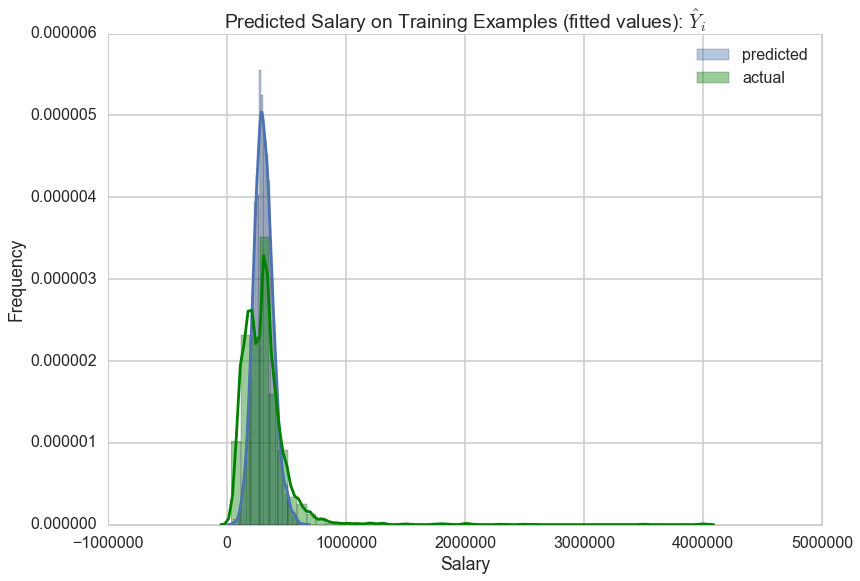

In [20]:
sns.distplot(pipeline.predict(X_train), label='predicted')
sns.distplot(y_train, color='g', label='actual')
plt.title('Predicted Salary on Training Examples (fitted values): $\hat{Y}_i$')
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.legend(loc='best');

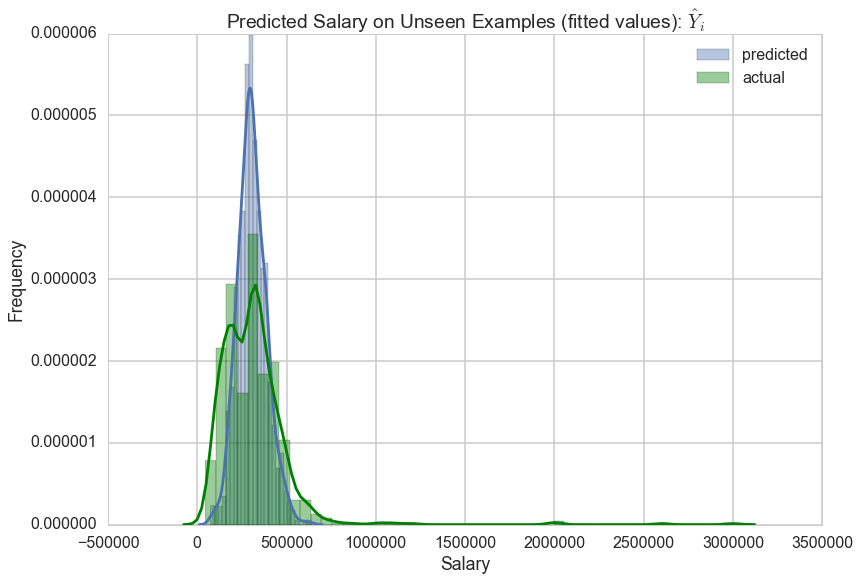

In [21]:
sns.distplot(pipeline.predict(X_test), label='predicted')
sns.distplot(y_test, color='g', label='actual')
plt.title('Predicted Salary on Unseen Examples (fitted values): $\hat{Y}_i$')
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.legend(loc='best');

In [22]:
pred_comparison_train = pd.DataFrame(zip(y_train, pipeline.predict(X_train)), columns=['actual', 'predicted'])

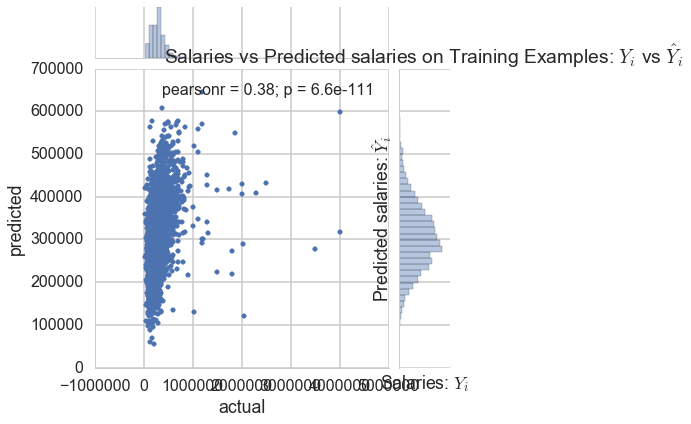

In [23]:
sns.jointplot(x='actual', y='predicted', data=pred_comparison_train)
plt.xlabel("Salaries: $Y_i$")
plt.ylabel("Predicted salaries: $\hat{Y}_i$")
plt.title("Salaries vs Predicted salaries on Training Examples: $Y_i$ vs $\hat{Y}_i$");

In [24]:
pred_comparison_test = pd.DataFrame(zip(y_test, pipeline.predict(X_test)), columns=['actual', 'predicted'])

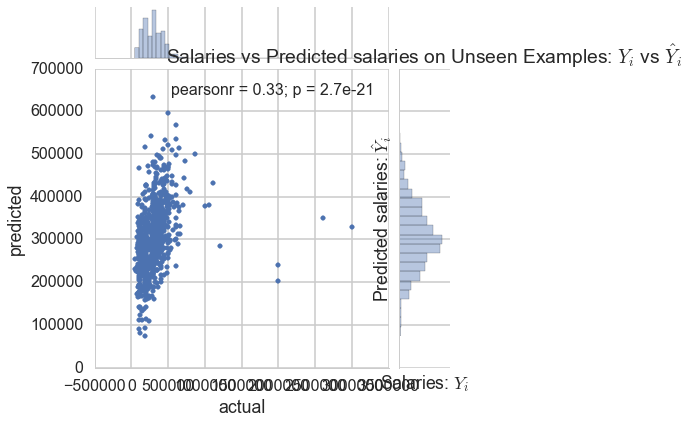

In [25]:
sns.jointplot(x='actual', y='predicted', data=pred_comparison_test)
plt.xlabel("Salaries: $Y_i$")
plt.ylabel("Predicted salaries: $\hat{Y}_i$")
plt.title("Salaries vs Predicted salaries on Unseen Examples: $Y_i$ vs $\hat{Y}_i$");

## Cross validation score

In [26]:
scores, mean = eval_models([pipeline], X_train, y_train)

score: 44743783737.864815
combined score: 44743783737.864815 
score: 49445652743.112640
combined score: 49445652743.112640 
score: 57970733423.967491
combined score: 57970733423.967491 
score: 42259306681.045250
combined score: 42259306681.045250 
score: 34082726863.842384
combined score: 34082726863.842384 


C:\Users\Abhishek\Anaconda2\lib\site-packages\sklearn\cross_validation.py:758: DeprecationWarning: The indices parameter is deprecated and will be removed (assumed True) in 0.17
  "removed (assumed True) in 0.17", DeprecationWarning)


In [27]:
print 'Mean cv score: {}, std: {} '.format(scores, mean)

Mean cv score: 45700440690.0, std: 7903348245.37 


In [28]:
mseTrain = np.mean((y_train - pipeline.predict(X_train)) ** 2)
mseTest = np.mean((y_test - pipeline.predict(X_test)) ** 2)

print 'Mean Squared Error on training examples %f ' %mseTrain
print 'Mean Squared Error on unseen examples %f ' %mseTest

Mean Squared Error on training examples 39143595298.303169 
Mean Squared Error on unseen examples 39273585573.507431 


## Lasso Regression

In [29]:
ft = FeatureTransformer(train, test)
sel = SelectKBest(f_regression, k=10)
scaler = StandardScaler()
lasso = Lasso(alpha=0.2)

In [30]:
pipeline = Pipeline([('transformer', ft), ('scaler', scaler), ('sel', sel), ('lasso', lasso)])

In [31]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('transformer', FeatureTransformer(test=None, train=None)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('sel', SelectKBest(k=10, score_func=<function f_regression at 0x000000001F767908>)), ('lasso', Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))])

In [32]:
lasso_comp = pipeline.get_params()['lasso']

In [33]:
print 'Estimated intercept coefficient:', lasso_comp.intercept_

Estimated intercept coefficient: 306946.216385


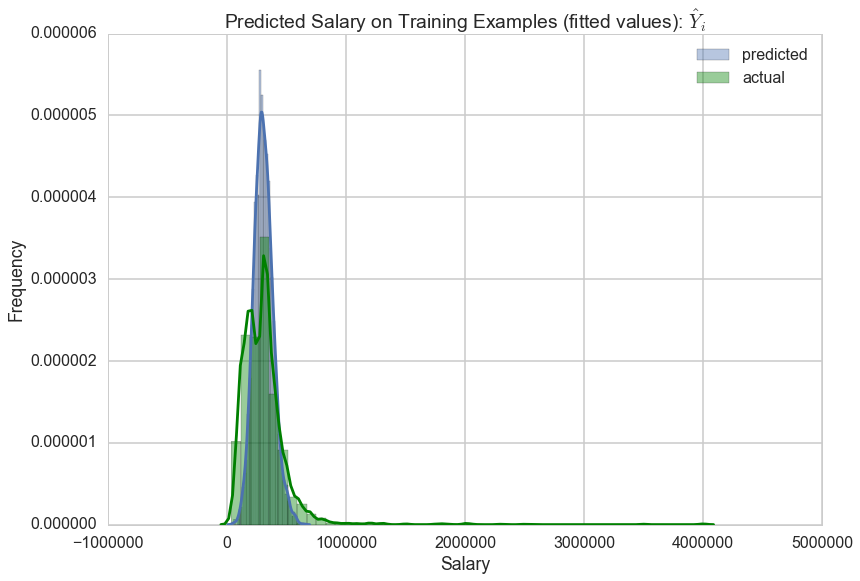

In [34]:
sns.distplot(pipeline.predict(X_train), label='predicted')
sns.distplot(y_train, color='g', label='actual')
plt.title('Predicted Salary on Training Examples (fitted values): $\hat{Y}_i$')
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.legend(loc='best');

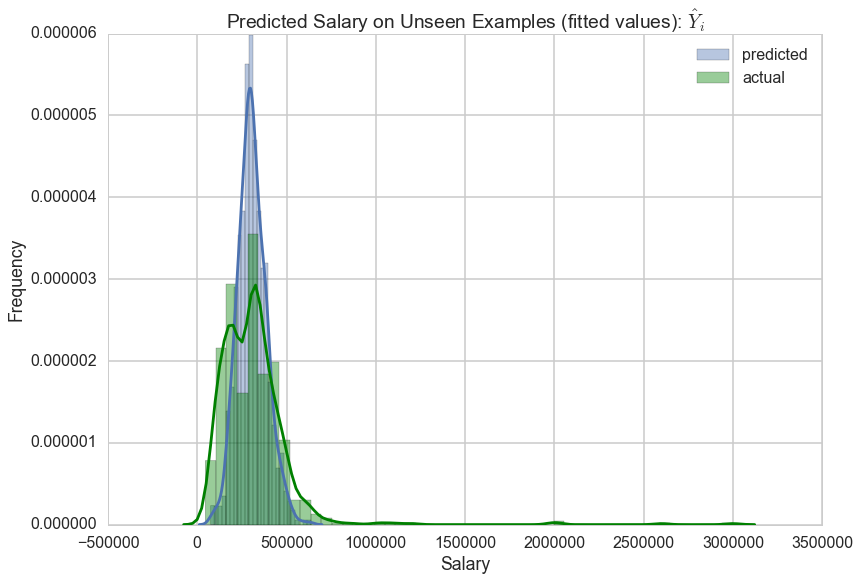

In [35]:
sns.distplot(pipeline.predict(X_test), label='predicted')
sns.distplot(y_test, color='g', label='actual')
plt.title('Predicted Salary on Unseen Examples (fitted values): $\hat{Y}_i$')
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.legend(loc='best');

## Cross validation scores

In [36]:
scores, mean = eval_models([pipeline], X_train, y_train)

score: 46858044588.422806
combined score: 46858044588.422806 
score: 8980828546636.878906
combined score: 8980828546636.878906 
score: 37993598732.155708
combined score: 37993598732.155708 
score: 48064911028.777603
combined score: 48064911028.777603 
score: 45268743311.583366
combined score: 45268743311.583366 


C:\Users\Abhishek\Anaconda2\lib\site-packages\sklearn\cross_validation.py:758: DeprecationWarning: The indices parameter is deprecated and will be removed (assumed True) in 0.17
  "removed (assumed True) in 0.17", DeprecationWarning)


In [37]:
print 'Mean cv score: {}, std: {} '.format(scores, mean)

Mean cv score: 1.83180276886e+12, std: 3.57451460058e+12 


In [38]:
mseTrain = np.mean((y_train - pipeline.predict(X_train)) ** 2)
mseTest = np.mean((y_test - pipeline.predict(X_test)) ** 2)

print 'Mean Squared Error on training examples %f ' %mseTrain
print 'Mean Squared Error on unseen examples %f ' %mseTest

Mean Squared Error on training examples 39063202520.043510 
Mean Squared Error on unseen examples 39229578653.321960 


## Ridge Regression

In [39]:
ft = FeatureTransformer(train, test)
sel = SelectKBest(f_regression, k=10)
scaler = StandardScaler()
ridge = Ridge()

In [40]:
pipeline = Pipeline([('transformer', ft), ('scaler', scaler), ('sel', sel), ('ridge', ridge)])

In [41]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('transformer', FeatureTransformer(test=None, train=None)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('sel', SelectKBest(k=10, score_func=<function f_regression at 0x000000001F767908>)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, solver='auto', tol=0.001))])

In [42]:
ridge_comp = pipeline.get_params()['ridge']

In [43]:
print 'Estimated intercept coefficient:', ridge_comp.intercept_

Estimated intercept coefficient: 306946.216385


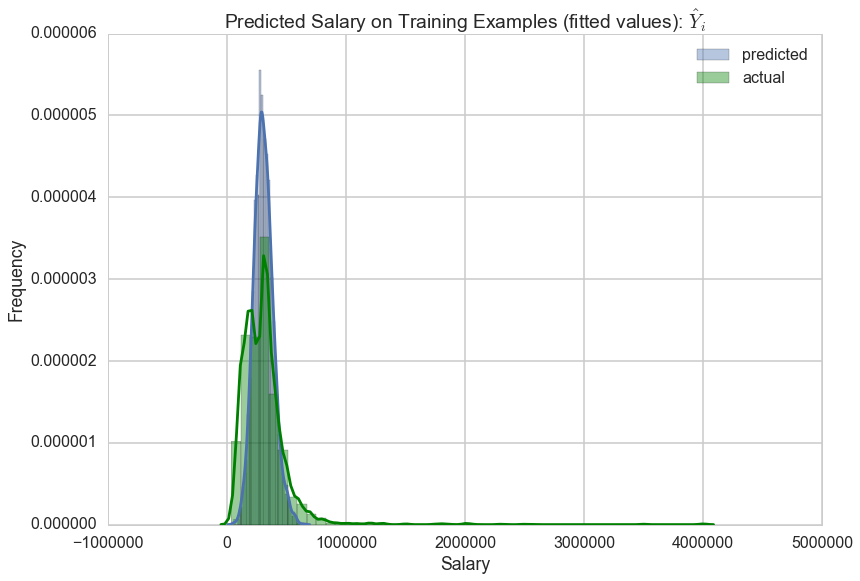

In [44]:
sns.distplot(pipeline.predict(X_train), label='predicted')
sns.distplot(y_train, color='g', label='actual')
plt.title('Predicted Salary on Training Examples (fitted values): $\hat{Y}_i$')
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.legend(loc='best');

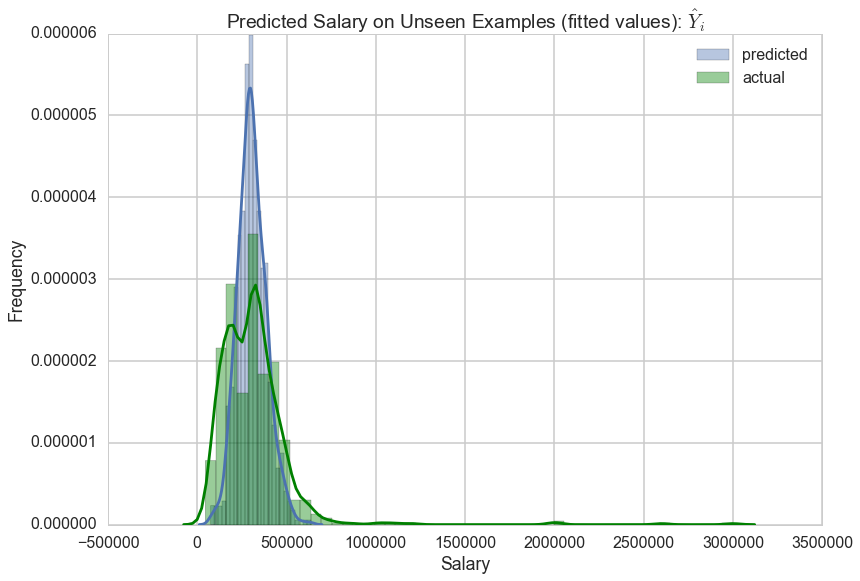

In [45]:
sns.distplot(pipeline.predict(X_test), label='predicted')
sns.distplot(y_test, color='g', label='actual')
plt.title('Predicted Salary on Unseen Examples (fitted values): $\hat{Y}_i$')
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.legend(loc='best');

## Cross validation scores

In [46]:
scores, mean = eval_models([pipeline], X_train, y_train)

score: 47768765444.639061
combined score: 47768765444.639061 
score: 30103986089.473663
combined score: 30103986089.473663 
score: 61665422765.184898
combined score: 61665422765.184898 
score: 6323638343269.081055
combined score: 6323638343269.081055 
score: 5642411510547.071289
combined score: 5642411510547.071289 


C:\Users\Abhishek\Anaconda2\lib\site-packages\sklearn\cross_validation.py:758: DeprecationWarning: The indices parameter is deprecated and will be removed (assumed True) in 0.17
  "removed (assumed True) in 0.17", DeprecationWarning)


In [47]:
print 'Mean cv score: {}, std: {} '.format(scores, mean)

Mean cv score: 2.42111760562e+12, std: 2.91626980846e+12 


In [48]:
mseTrain = np.mean((y_train - pipeline.predict(X_train)) ** 2)
mseTest = np.mean((y_test - pipeline.predict(X_test)) ** 2)

print 'Mean Squared Error on training examples %f ' %mseTrain
print 'Mean Squared Error on unseen examples %f ' %mseTest

Mean Squared Error on training examples 1163030525361.815918 
Mean Squared Error on unseen examples 38760512218.311333 


## Random Forest Regression

In [49]:
from sklearn.ensemble import RandomForestRegressor

In [50]:
ft = FeatureTransformer(train, test)
scaler = StandardScaler()
sel = SelectKBest(f_regression, k=20)
rf = RandomForestRegressor(n_estimators=500, n_jobs=-1)

In [51]:
pipeline = Pipeline([('transformer', ft), ('scaler', scaler), ('sel', sel), ('rf', rf)])

In [52]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('transformer', FeatureTransformer(test=None, train=None)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('sel', SelectKBest(k=20, score_func=<function f_regression at 0x000000001F767908>)), ('rf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,...mators=500, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False))])

In [53]:
rf_comp = pipeline.get_params()['rf']

In [54]:
# Feature Importance
feat_importances = pd.DataFrame(zip(feature_names, rf_comp.feature_importances_), columns = ['features', 'importance'])

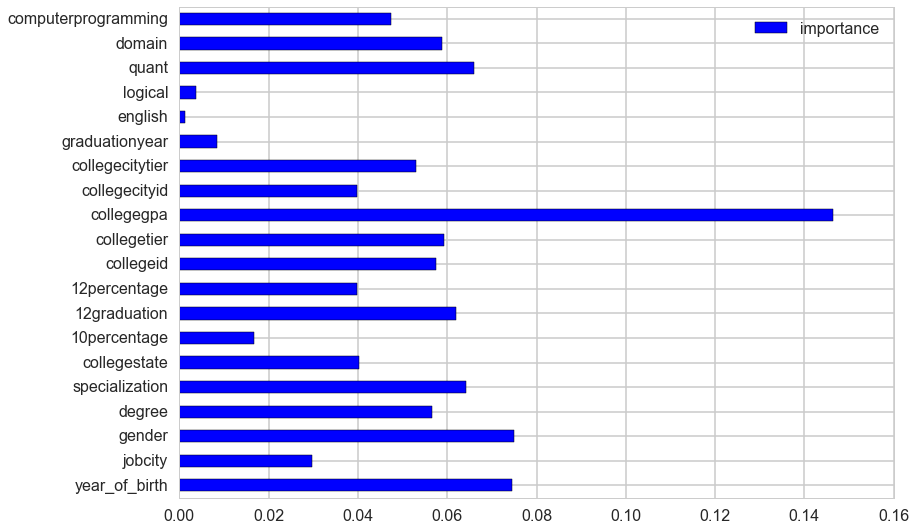

In [55]:
feat_importances.plot(kind='barh')
plt.yticks(feat_importances.index.values, feat_importances.features, rotation='horizontal');

In [56]:
predsTrain = pipeline.predict(X_train)
predsTest = pipeline.predict(X_test)

In [57]:
# lets take a look at first five predicted values
predsTrain[0:5]

array([ 313550.,  196200.,  371650.,  345180.,  147120.])

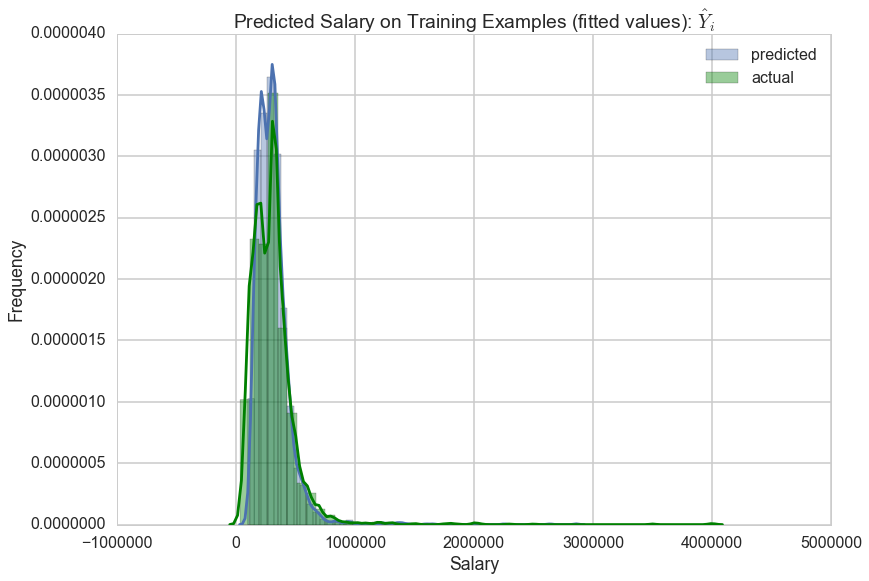

In [58]:
sns.distplot(predsTrain, label='predicted')
sns.distplot(y_train, color='g', label='actual')
plt.title('Predicted Salary on Training Examples (fitted values): $\hat{Y}_i$')
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.legend(loc='best');

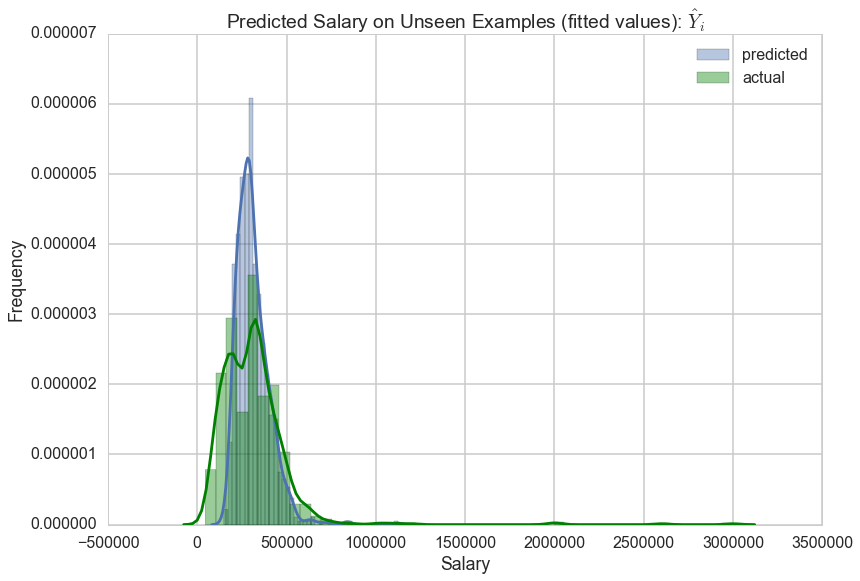

In [59]:
sns.distplot(predsTest, label='predicted')
sns.distplot(y_test, color='g', label='actual')
plt.title('Predicted Salary on Unseen Examples (fitted values): $\hat{Y}_i$')
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.legend(loc='best');

In [60]:
pred_comparison_train = pd.DataFrame(zip(y_train, predsTrain), columns=['actual', 'predicted'])

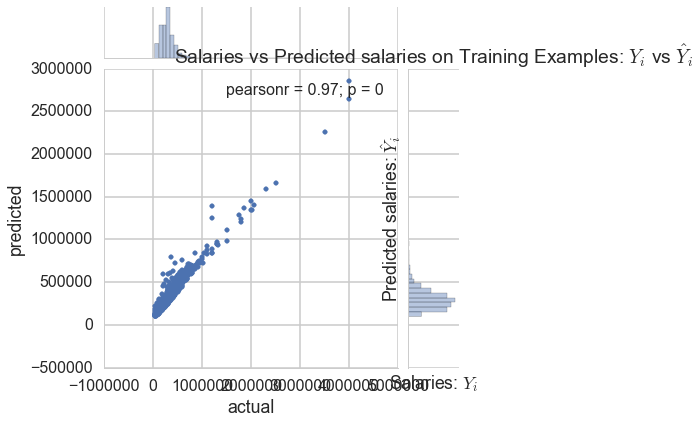

In [61]:
sns.jointplot(x='actual', y='predicted', data=pred_comparison_train)
plt.xlabel("Salaries: $Y_i$")
plt.ylabel("Predicted salaries: $\hat{Y}_i$")
plt.title("Salaries vs Predicted salaries on Training Examples: $Y_i$ vs $\hat{Y}_i$");

In [62]:
pred_comparison_test = pd.DataFrame(zip(y_test, predsTest), columns=['actual', 'predicted'])

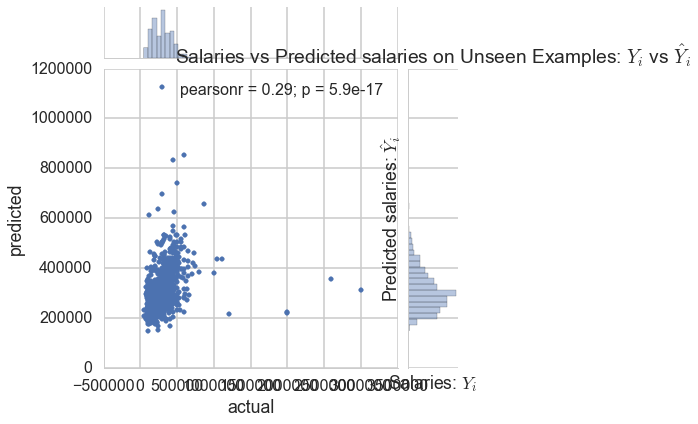

In [63]:
sns.jointplot(x='actual', y='predicted', data=pred_comparison_test)
plt.xlabel("Salaries: $Y_i$")
plt.ylabel("Predicted salaries: $\hat{Y}_i$")
plt.title("Salaries vs Predicted salaries on Unseen Examples: $Y_i$ vs $\hat{Y}_i$");

## Cross validation scores

In [ ]:
scores, mean = eval_models([pipeline], X_train, y_train)

In [ ]:
print 'Mean cv score: {}, std: {} '.format(scores, mean)

In [ ]:
mseTrain = np.mean((y_train - predsTrain) ** 2)
mseTest = np.mean((y_test - predsTest) ** 2)

print 'Mean Squared Error on training examples %f ' %mseTrain
print 'Mean Squared Error on unseen examples %f ' %mseTest

## Gradient Boosting Machines

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
ft = FeatureTransformer(train, test)
scaler = StandardScaler()
sel = SelectKBest(f_regression, k=20)
gbr = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.01, subsample=0.8)

In [ ]:
pipeline = Pipeline([('transformer', ft), ('scaler', scaler), ('sel', sel), ('gbr', gbr)])

In [ ]:
pipeline.fit(X_train, y_train)

In [ ]:
predsTrain = pipeline.predict(X_train)
predsTest = pipeline.predict(X_test)

In [ ]:
# lets take a look at first five predicted values
predsTrain[0:5]

In [ ]:
sns.distplot(predsTrain, label='predicted')
sns.distplot(y_train, color='g', label='actual')
plt.title('Predicted Salary on Training Examples (fitted values): $\hat{Y}_i$')
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.legend(loc='best');

In [ ]:
sns.distplot(predsTest, label='predicted')
sns.distplot(y_test, color='g', label='actual')
plt.title('Predicted Salary on Unseen Examples (fitted values): $\hat{Y}_i$')
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.legend(loc='best');

## Cross validation scores

In [ ]:
scores, mean = eval_models([pipeline], X_train, y_train)

In [ ]:
print 'Mean cv score: {}, std: {} '.format(scores, mean)

In [ ]:
mseTrain = np.mean((y_train - predsTrain) ** 2)
mseTest = np.mean((y_test - predsTest) ** 2)

print 'Mean Squared Error on training examples %f ' %mseTrain
print 'Mean Squared Error on unseen examples %f ' %mseTest

## Linear SVM

In [ ]:
from sklearn.svm import SVR

In [ ]:
ft = FeatureTransformer(train, test)
scaler = StandardScaler()
sel = SelectKBest(f_regression, k=20)
svr = SVR(kernel='linear', C=50.0)

In [ ]:
pipeline = Pipeline([('transformer', ft), ('scaler', scaler), ('sel', sel), ('svr', svr)])

In [ ]:
pipeline.fit(X_train, y_train)

In [ ]:
predsTrain = pipeline.predict(X_train)
predsTest = pipeline.predict(X_test)

In [ ]:
# lets take a look at first five predicted values
predsTrain[0:5]

In [ ]:
sns.distplot(predsTrain, label='predicted')
sns.distplot(y_train, color='g', label='actual')
plt.title('Predicted Salary on Training Examples (fitted values): $\hat{Y}_i$')
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.legend(loc='best');

In [ ]:
sns.distplot(predsTest, label='predicted')
sns.distplot(y_test, color='g', label='actual')
plt.title('Predicted Salary on Unseen Examples (fitted values): $\hat{Y}_i$')
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.legend(loc='best');

## Cross validation scores

In [ ]:
scores, mean = eval_models([pipeline], X_train, y_train)

In [ ]:
print 'Mean cv score: {}, std: {} '.format(scores, mean)

In [ ]:
mseTrain = np.mean((y_train - predsTrain) ** 2)
mseTest = np.mean((y_test - predsTest) ** 2)

print 'Mean Squared Error on training examples %f ' %mseTrain
print 'Mean Squared Error on unseen examples %f ' %mseTest

** Till now linear regession is producing surprisingly best results, when all other models are over-predicting for most of the examples. **

## Ensemble of models

In [ ]:
pipeline_ridge = Pipeline([('transformer', ft), ('scaler', scaler), ('sel', sel), ('ridge', ridge)])
pipeline_linear_svm = Pipeline([('transformer', ft), ('scaler', scaler), ('sel', sel), ('svr', svr)])
pipeline_gbr = Pipeline([('transformer', ft), ('scaler', scaler), ('sel', sel), ('gbr', gbr)])

In [ ]:
# Cross validation scores
scores, mean = eval_models([pipeline_ridge, pipeline_linear_svm], X_train, y_train)

In [ ]:
print 'Mean cv score: {}, std: {} '.format(scores, mean)

In [ ]:
predsTrain = (pipeline_ridge.predict(X_train) + pipeline_linear_svm.predict(X_train)) / 2.
predsTest = (pipeline_ridge.predict(X_test) + pipeline_linear_svm.predict(X_test)) / 2.

In [ ]:
mseTrain = np.mean((y_train - predsTrain) ** 2)
mseTest = np.mean((y_test - predsTest) ** 2)

print 'Mean Squared Error on training examples %f ' %mseTrain
print 'Mean Squared Error on unseen examples %f ' %mseTest